In [1]:
# Run if nltk not installed
# import nltk
# nltk.download('all')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import string, re, emoji
import random

# Limpieza de textos
from pattern.text.en import singularize, lemma
from nltk.corpus import stopwords

from wordcloud import WordCloud

# Sentimientos
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

pd.options.display.max_rows = 10
import time

In [3]:
train = pd.read_csv('./train.csv', encoding='utf8')
cachedStopWords = stopwords.words('english')

In [4]:
train.columns

Index(['userName', 'userLocation', 'userDescription', 'isUserVerified', 'date',
       'text', 'source'],
      dtype='object')

# Analisis Exploratorio I

<AxesSubplot:>

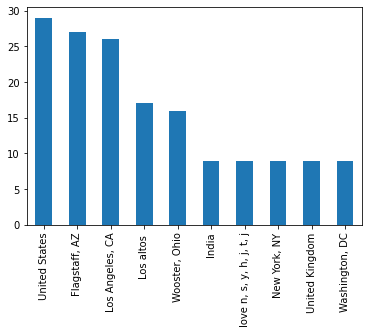

In [5]:
train['userLocation'].value_counts().head(10).plot.bar()

False    1486
True       14
Name: isUserVerified, dtype: int64


<AxesSubplot:>

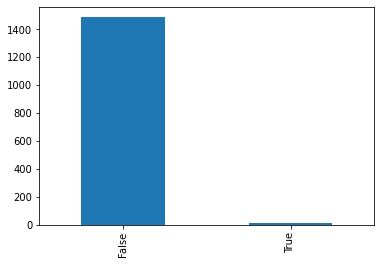

In [6]:
print(train['isUserVerified'].value_counts())
train['isUserVerified'].value_counts().head(10).plot.bar()

<AxesSubplot:>

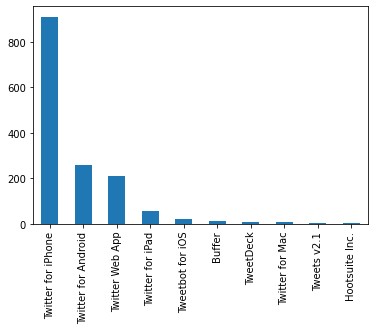

In [7]:
train['source'].value_counts().head(10).plot.bar()

In [8]:
train

,userName,userLocation,userDescription,isUserVerified,date,text,source
0,brian parchamento,NaN,YouTube Profiles: #brianparchamento #b1cyberne...,False,2022-09-12 01:49:03+00:00,"@Apple Yes...Not ""Indeed""...BUT OK..""i Guess i...",Twitter Web App
1,Asifullah Khan,"Las Vegas, NV","Like A Drug Addictive, Expensive, Complicated.",False,2022-09-12 01:48:41+00:00,@Apple I was gonna upgrade but I need the vers...,Twitter for iPhone
2,MW ✨,Small town Oklahoma,"Aggressively unfancy, #BlackLivesMatter #GoodT...",False,2022-09-12 01:47:06+00:00,"Google just dropped Trump's ""Truth Social"" ove...",Twitter for iPhone
3,D clax,NaN,"Firefighter Emt, powerlifter, husband, dad",False,2022-09-12 01:46:33+00:00,@Apple To bad it’s 2 month back ordered. So si...,Twitter for iPhone
4,Rachelle Olaridge,Ohio,"Teacher, Educator, Mentor, Missionary, Lady, D...",False,2022-09-12 01:46:30+00:00,@Apple Let me when the phone is no longer made...,Twitter for Android
...,...,...,...,...,...,...,...
1495,Adamas Nemesis,NaN,Blogger. Investor. Science-fiction author. Bal...,False,2022-09-11 14:56:48+00:00,@nicky_blender @Apple Wonderful.,Twitter Web App
1496,TheCoinKing.ZIL or .TEZ,NOT your financial advisor,YouTube https://t.co/zSTFRAPpux\n\n$ZIL $DOT $...,False,2022-09-11 14:56:14+00:00,@jonodnz @Apple *alive I meant,Twitter for Android
1497,TheCoinKing.ZIL or .TEZ,NOT your financial advisor,YouTube https://t.co/zSTFRAPpux\n\n$ZIL $DOT $...,False,2022-09-11 14:55:45+00:00,@jonodnz @Apple Job is a visionary leader ...A...,Twitter for Android
1498,Alan Dail⚡️🔋🇺🇦,"Wooster, Ohio",Sustainable Energy • Longevity • Virtual Reality,False,2022-09-11 14:55:18+00:00,@MissJilianne @blckTSLA @Apple The current 10....,Twitter Web App


# Limpieza de datos

In [9]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value

def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def replaceSpace(value):
  return str(value).replace('%20', ' ')

def removeHastags(value):
  if ('#' not in value): return value
  hashtags = re.findall(r"#[^\s]*", value, re.I)
  for hashtag in hashtags:
    value = value.replace(hashtag, '')
  return value

def removeLinks(value):
  if ('http' not in value): return value
  links = re.findall(r"http[^\s]*", value, re.I)
  for link in links:
    value = value.replace(link, '')
  return value

def removeStepWords(value):
  return ' '.join([word for word in value.split() if word not in cachedStopWords])

def extractEmojis(value):
  return emoji.replace_emoji(value, '')

def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

cleanText = []
for index, row in train.iterrows():
  text = row['text'][:]

  # Limpiando el texto
  text = text.lower()                         # Convierte todo a minusculas
  text = text.replace('utc', ' ')             # Quita utc
  text = text.replace('\n', ' ')              # Quita \n

  # Quita menciones
  hashtags = re.findall(r"#\S+", text, re.I)
  if (len(hashtags) > 0):
    for hashtag in hashtags:
      text = text.replace(hashtag, '')

  # Quita menciones
  mentions = re.findall(r"@\S+", text, re.I)
  if (len(mentions) > 0):
    for mention in mentions:
      text = text.replace(mention, '')
  
  text = removeLinks(text)                    # Quita links
  text = extractEmojis(text)                  # Quita todos los emojis
  text = text.translate(translator)           # Quita todos los signos de puntuacion
  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas
  text = sentenceToSingular(text)             # Pasa las palabras a singular
  text = sentenceToPresent(text)              # Pasa las palabras a presente
  
  # Quitando numeros, pero algo como 5g no se elminara
  numbers = re.findall(r"[0-9]+\s", text, re.I)
  if (len(numbers) > 0):
    for number in numbers:
      text = text.replace(number, '')

  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas

  cleanText.append(text)

train['cleanText'] = cleanText[:]

In [10]:
train

,userName,userLocation,userDescription,isUserVerified,date,text,source,cleanText
0,brian parchamento,NaN,YouTube Profiles: #brianparchamento #b1cyberne...,False,2022-09-12 01:49:03+00:00,"@Apple Yes...Not ""Indeed""...BUT OK..""i Guess i...",Twitter Web App,ye indee ok gue ido happier
1,Asifullah Khan,"Las Vegas, NV","Like A Drug Addictive, Expensive, Complicated.",False,2022-09-12 01:48:41+00:00,@Apple I was gonna upgrade but I need the vers...,Twitter for iPhone,gonna upgrade need versatility physical sim card
2,MW ✨,Small town Oklahoma,"Aggressively unfancy, #BlackLivesMatter #GoodT...",False,2022-09-12 01:47:06+00:00,"Google just dropped Trump's ""Truth Social"" ove...",Twitter for iPhone,google drop trump truth social app promotion v...
3,D clax,NaN,"Firefighter Emt, powerlifter, husband, dad",False,2022-09-12 01:46:33+00:00,@Apple To bad it’s 2 month back ordered. So si...,Twitter for iPhone,bad it’ month back order silly that’ issue day...
4,Rachelle Olaridge,Ohio,"Teacher, Educator, Mentor, Missionary, Lady, D...",False,2022-09-12 01:46:30+00:00,@Apple Let me when the phone is no longer made...,Twitter for Android,let phone longer make another country
...,...,...,...,...,...,...,...,...
1495,Adamas Nemesis,NaN,Blogger. Investor. Science-fiction author. Bal...,False,2022-09-11 14:56:48+00:00,@nicky_blender @Apple Wonderful.,Twitter Web App,wonderful
1496,TheCoinKing.ZIL or .TEZ,NOT your financial advisor,YouTube https://t.co/zSTFRAPpux\n\n$ZIL $DOT $...,False,2022-09-11 14:56:14+00:00,@jonodnz @Apple *alive I meant,Twitter for Android,alive mean
1497,TheCoinKing.ZIL or .TEZ,NOT your financial advisor,YouTube https://t.co/zSTFRAPpux\n\n$ZIL $DOT $...,False,2022-09-11 14:55:45+00:00,@jonodnz @Apple Job is a visionary leader ...A...,Twitter for Android,job visionary leader apple without take compan...
1498,Alan Dail⚡️🔋🇺🇦,"Wooster, Ohio",Sustainable Energy • Longevity • Virtual Reality,False,2022-09-11 14:55:18+00:00,@MissJilianne @blckTSLA @Apple The current 10....,Twitter Web App,current x even limit apple developer betum tes...


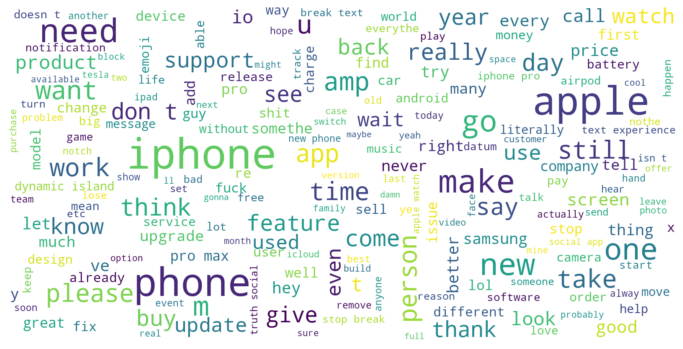

In [11]:
#Disaster Tweets wordcloud 
disaster_tweets = train[:]
disaster_string = []
for t in disaster_tweets.cleanText:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentimientos

In [12]:
def classifyTweet(dfToClassify):
    subjectivityValues = []
    positiveValues = []
    polarityValues = []

    for text in dfToClassify.cleanText:
        sent = TextBlob(text)
        subjectivity  = sent.sentiment.subjectivity
        polarity  = sent.sentiment.polarity

        sent = TextBlob(text, analyzer = NaiveBayesAnalyzer())
        classification = sent.sentiment.classification
        positiveScore = sent.sentiment.p_pos

        polarityValues.append(polarity)
        subjectivityValues.append(subjectivity)
        positiveValues.append(positiveScore)
    
    return [polarityValues, subjectivityValues, positiveValues]

In [13]:
exploratory = train.sample(307)

In [14]:
polarityValues, subjectivityValues, positiveValues = classifyTweet(exploratory)

In [15]:
exploratory['polarityValues'] = polarityValues
exploratory['subjectivity'] = subjectivityValues
exploratory['positive'] = positiveValues

In [16]:
exploratory.describe()

,polarityValues,subjectivity,positive
count,307.000000,307.000000,307.000000
mean,0.075652,0.300128,0.537657
std,0.267921,0.299120,0.248210
min,-1.000000,0.000000,0.026862
25%,0.000000,0.000000,0.370756
50%,0.000000,0.250000,0.521729
75%,0.200000,0.533333,0.729798
max,1.000000,1.000000,0.998469


<AxesSubplot:>

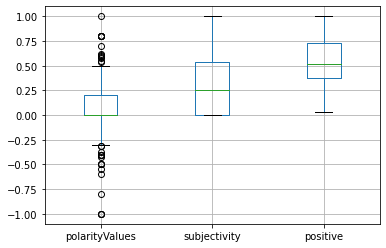

In [17]:
boxplot = exploratory.boxplot(column=['polarityValues', 'subjectivity', 'positive'])
boxplot